# Analytics - Product Quality

#### Date: 2022/01

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: 2022/1
##### Professor: Hilmer Neri

##### Members:

- Guilherme Leal
- João Pedro Soares
- Lucas Alexandre
- Matheus Estanislau
- Moacir Mascarenha
- Igor Silva de Paiva
- João Pedro Alves Machado
- Mário Vinícius
- Lucas Heler Lopes
- Pedro Siqueira
- Wildemberg Sales da Silva Junior

### LIBRARIES

In [1]:
# Deal with data
import pandas as pd
import json
from glob import glob
import os
import re

# Deal with visualization
import matplotlib.pyplot as plt

# Deal with time
import datetime

### GRAPH SETTINGS

In [2]:
fig = plt.figure(figsize=(20, 10))

<Figure size 2000x1000 with 0 Axes>

### DATAFRAME SETTINGS

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

#### Replace your semester, project name, repository name, and the programming language extension

In [4]:
language = [['fga-eps-mds-2022-1-Alectrion-FrontEnd', 'ts'],
           ['fga-eps-mds-2022-1-Alectrion-UserAPI', 'ts'],
           ['fga-eps-mds-2022-1-Alectrion-EquipamentApi', 'ts']]

repos_language = {}

for item in language:
    repos_language[f"{item[0]}"] = item[1]

### SonarCloud

##### Path to the folder with all your jsons

In [5]:
jsons = glob('analytics-raw-data/*.json') # add your path here

In [6]:
def read_json(json_path):
    
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
        
    return json_obj

def create_base_component_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        base_component = read_json(i)

        base_component_data = base_component['baseComponent']['measures']

        base_component_df = pd.DataFrame(base_component_data)

        base_component_df['filename'] = os.path.basename(i)

        df = df.append(base_component_df, ignore_index=True)
        
    # Replace the UnB semester with yours.
    aux_df = df['filename'].str.split(r"fga-eps-mds-2022.1-(.*?)-(.*?)-(.*?)-(.*?)-v(.*?).json", expand=True)

    df['repository'] = aux_df[2]

    df['version'] = aux_df[5]

    df = df.sort_values(by=['repository', 'version'])
        
    return df

#### Create base component dataframe

In [7]:
base_component_df = create_base_component_df(jsons)

/tmp/ipykernel_3622/1251919851.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_3622/1251919851.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_3622/1251919851.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_3622/1251919851.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(base_component_df, ignore_index=True)
/tmp/ipykernel_3622/1251919851.py:22: FutureWarning: The frame.append method is deprecated and w

In [8]:
base_component_df.head(10)

,metric,value,bestValue,filename,repository,version
51,duplicated_lines_density,0.0,True,fga-eps-mds-2022-1-Alectrion-EquipamentApi-09-...,EquipamentApi,0.2.0
52,functions,2,NaN,fga-eps-mds-2022-1-Alectrion-EquipamentApi-09-...,EquipamentApi,0.2.0
53,security_rating,1.0,True,fga-eps-mds-2022-1-Alectrion-EquipamentApi-09-...,EquipamentApi,0.2.0
54,files,2,NaN,fga-eps-mds-2022-1-Alectrion-EquipamentApi-09-...,EquipamentApi,0.2.0
55,complexity,3,NaN,fga-eps-mds-2022-1-Alectrion-EquipamentApi-09-...,EquipamentApi,0.2.0
56,ncloc,19,NaN,fga-eps-mds-2022-1-Alectrion-EquipamentApi-09-...,EquipamentApi,0.2.0
57,coverage,0.0,False,fga-eps-mds-2022-1-Alectrion-EquipamentApi-09-...,EquipamentApi,0.2.0
58,comment_lines_density,0.0,False,fga-eps-mds-2022-1-Alectrion-EquipamentApi-09-...,EquipamentApi,0.2.0
99,duplicated_lines_density,0.0,True,fga-eps-mds-2022-1-Alectrion-EquipamentApi-09-...,EquipamentApi,0.3.0
100,functions,16,NaN,fga-eps-mds-2022-1-Alectrion-EquipamentApi-09-...,EquipamentApi,0.3.0


#### Create dataframe per file

In [9]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

len(metric_list)

12

In [10]:
def metric_per_file(json):
    
    file_json = []
    
    for component in json['components']:
        if component['qualifier'] == 'FIL':
            file_json.append(component)
            
    return file_json

def generate_file_dataframe_per_release(metric_list, json, language_extension):
    
    df_columns = metric_list
    df = pd.DataFrame(columns = df_columns)
    
    for file in json:
        try:
            if file['language'] == language_extension:
                for measure in file['measures']:
                    df.at[file['path'], measure['metric']] = measure['value']
        except:
            pass
        
    df.reset_index(inplace = True)
    df = df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    return df

def create_file_df(json_list):
    
    df = pd.DataFrame()

    for i in json_list:

        file_component = read_json(i)
        
        file_component_data = metric_per_file(file_component)

        file_name = os.path.basename(i)

        file_repository = re.split(r'-(\d+-\d+-\d+-\d+-\d+-\d+)-v(.*?).json', file_name)[0]

        file_language = repos_language[f"{file_repository}"]

        file_component_df = generate_file_dataframe_per_release(metric_list, file_component_data, language_extension = file_language)

        file_component_df['filename'] = os.path.basename(i)

        df = df.append(file_component_df, ignore_index=True)
        
    # Replace the UnB semester with yours.
    aux_df = df['filename'].str.split(r"-(\d+-\d+-\d+-\d+-\d+-\d+)-v(.*?).json", expand=True)

    df['repository'] = aux_df[0]

    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'version'])

    return df

In [11]:
file_component_df = create_file_df(jsons)
file_component_df.repository.unique()

/tmp/ipykernel_3622/688069433.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_3622/688069433.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_3622/688069433.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_3622/688069433.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(file_component_df, ignore_index=True)
/tmp/ipykernel_3622/688069433.py:49: FutureWarning: The frame.append method is deprecated and will b

array(['fga-eps-mds-2022-1-Alectrion-EquipamentApi',
       'fga-eps-mds-2022-1-Alectrion-FrontEnd',
       'fga-eps-mds-2022-1-Alectrion-UserAPI'], dtype=object)

#### Removing NaN

In [12]:
file_component_df = file_component_df.dropna(subset=['functions', 'complexity','comment_lines_density', 'duplicated_lines_density', 'coverage'])

        #### Create dataframe per repository

In [13]:
# Example. You must replace repo1, repo1,..., for your repository's names

repo1_df = file_component_df[file_component_df['repository'] == 'fga-eps-mds-2022-1-Alectrion-FrontEnd']
repo2_df = file_component_df[file_component_df['repository'] == 'fga-eps-mds-2022-1-Alectrion-UserAPI']
repo3_df = file_component_df[file_component_df['repository'] == 'fga-eps-mds-2022-1-Alectrion-EquipamentApi']

In [14]:
def _ncloc(df):
    ncloc = 0
    for each in df['ncloc']:
        n = 0
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

### Measure calculations according Q-Rapids quality model

# Quality Aspect - Maintainability
## Factor - Code Quality

##### COMPLEXITY

In [15]:
def m1(df):
    
    density_non_complex_files = len(df[(df['complexity'].astype(float)/df['functions'].astype(float)) < 10])/len(df)
    
    return density_non_complex_files

##### COMMENTS

In [16]:
def m2(df):
    
    density_comment_files = len(df[(df['comment_lines_density'].astype(float) > 10) & (df['comment_lines_density'].astype(float) < 30)])/len(df)
    
    return density_comment_files

##### DUPLICATIONS

In [17]:
def m3(df):
    
    duplication = len(df[(df['duplicated_lines_density'].astype(float) < 5)])/len(df)
    
    return duplication

# Quality Aspect - Reliability
## Factor - Testing Status

##### Passed tests

In [18]:
def m4(df):
    #passed_tests = (float(df['tests']) - (float(df['test_errors']) + float(df['test_failures']))) / float(df['tests'])
    passed_tests = 0

    return passed_tests

##### Fast test builds

In [19]:
def m5(df):
    #density_fast_test_builds = len(df[(df['test_execution_time'].astype(float)) < 300]) / sum(df['tests'].astype(float))
    density_fast_test_builds = 0
    return density_fast_test_builds

##### Test coverage

In [20]:
def m6(df):

    density_test_coverage = len(df[(df['coverage'].astype(float) > 60)]) / len(df)

    return density_test_coverage

### Calculate m1, m2, m3, m4, m5 and m6 for each repository

In [21]:
def create_metrics_df(df):
    
    version_vec = df['version'].unique()
    
    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []
    
    print("df = ", df)
    print("version_vec = ", version_vec)
    
    for version in version_vec:

        version_df = df[df['version'] == version]

        m1_list.append(m1(version_df))
        m2_list.append(m2(version_df))
        m3_list.append(m3(version_df))
        m4_list.append(m4(version_df))
        m5_list.append(m5(version_df))
        m6_list.append(m6(version_df))

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)
        
    metrics_df = pd.DataFrame({'m1': m1_list,
                               'm2': m2_list,
                               'm3': m3_list,
                               'm4': m4_list,
                               'm5': m5_list,
                               'm6': m6_list,
                               'repository': repository_list, 
                               'version': version_list,
                               'ncloc': ncloc_list})
        
    return metrics_df

In [22]:
repo1 = create_metrics_df(repo1_df)
repo2 = create_metrics_df(repo2_df)
repo3 = create_metrics_df(repo3_df)

df =                                               path functions complexity  \
1                               src/api/config.ts         0          0   
2                               src/config/env.ts         0          0   
3        src/components/text-field/index.test.tsx         1          1   
4        src/components/select-job/index.test.tsx         2          2   
5    src/components/select-profile/index.test.tsx         2          2   
6            src/components/button/index.test.tsx         1          1   
7            src/components/NavBar/index.test.tsx         1          1   
8               src/pages/EditUser/index.test.tsx         3          3   
9          src/pages/user-register/index.test.tsx         4          4   
10            src/components/text-field/index.tsx         1          1   
11        src/components/edit-user-form/index.tsx         4         16   
12            src/components/select-job/index.tsx         1          1   
13        src/components/select-

### Data visualization

- You must do this for each of your repositories

In [23]:
#AlectrionFrontEnd
repo1

,m1,m2,m3,m4,m5,m6,repository,version,ncloc
0,0.838710,0.032258,1.0,0,0,0.677419,fga-eps-mds-2022-1-Alectrion-FrontEnd,0.12.0,1254
1,1.000000,0.000000,1.0,0,0,0.666667,fga-eps-mds-2022-1-Alectrion-FrontEnd,0.13.0,290
2,0.000000,0.000000,1.0,0,0,1.000000,fga-eps-mds-2022-1-Alectrion-FrontEnd,0.14.0,3
3,0.838710,0.032258,1.0,0,0,0.677419,fga-eps-mds-2022-1-Alectrion-FrontEnd,0.15.0,1254
4,0.838710,0.032258,1.0,0,0,0.677419,fga-eps-mds-2022-1-Alectrion-FrontEnd,0.16.0,1252
5,0.941176,0.117647,1.0,0,0,0.705882,fga-eps-mds-2022-1-Alectrion-FrontEnd,0.17.0,927
6,1.000000,0.000000,1.0,0,0,1.000000,fga-eps-mds-2022-1-Alectrion-FrontEnd,0.18.0,59


In [24]:
#AlectrionUserApi
repo2

,m1,m2,m3,m4,m5,m6,repository,version,ncloc
0,0.777778,0.0,1.0,0,0,0.111111,fga-eps-mds-2022-1-Alectrion-UserAPI,0.12.0,235
1,0.666667,0.0,1.0,0,0,0.000000,fga-eps-mds-2022-1-Alectrion-UserAPI,0.13.0,40
2,0.857143,0.0,1.0,0,0,0.214286,fga-eps-mds-2022-1-Alectrion-UserAPI,0.14.0,433
3,0.923077,0.0,1.0,0,0,0.307692,fga-eps-mds-2022-1-Alectrion-UserAPI,0.15.0,465
4,0.777778,0.0,1.0,0,0,0.111111,fga-eps-mds-2022-1-Alectrion-UserAPI,0.9.0,235


In [25]:
#AlectrionEquipmentApi
repo3

,m1,m2,m3,m4,m5,m6,repository,version,ncloc
0,0.500000,0.0,1.0,0,0,0.000000,fga-eps-mds-2022-1-Alectrion-EquipamentApi,0.2.0,19
1,0.555556,0.0,1.0,0,0,0.000000,fga-eps-mds-2022-1-Alectrion-EquipamentApi,0.3.0,252
2,1.000000,0.0,1.0,0,0,0.148148,fga-eps-mds-2022-1-Alectrion-EquipamentApi,0.4.0,678
3,1.000000,0.0,1.0,0,0,0.090909,fga-eps-mds-2022-1-Alectrion-EquipamentApi,0.6.0,374


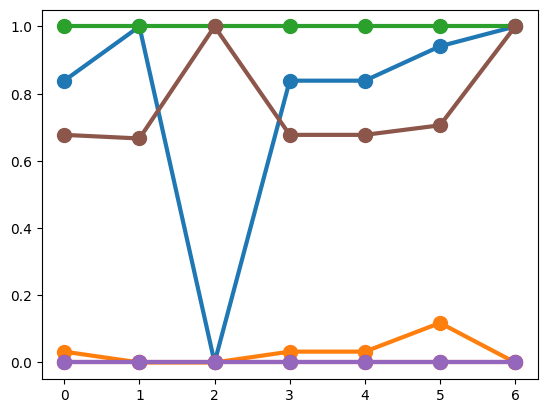

In [26]:
plt.plot(repo1['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(repo1['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(repo1['m3'], linewidth=3, marker='o', markersize=10)
plt.plot(repo1['m4'], linewidth=3, marker='o', markersize=10)
plt.plot(repo1['m5'], linewidth=3, marker='o', markersize=10)
plt.plot(repo1['m6'], linewidth=3, marker='o', markersize=10)

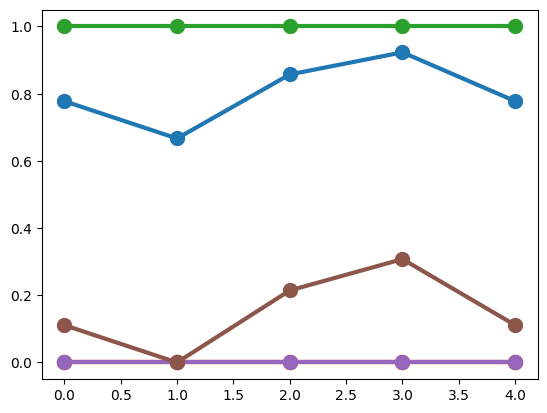

In [27]:
plt.plot(repo2['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(repo2['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(repo2['m3'], linewidth=3, marker='o', markersize=10)
plt.plot(repo2['m4'], linewidth=3, marker='o', markersize=10)
plt.plot(repo2['m5'], linewidth=3, marker='o', markersize=10)
plt.plot(repo2['m6'], linewidth=3, marker='o', markersize=10)

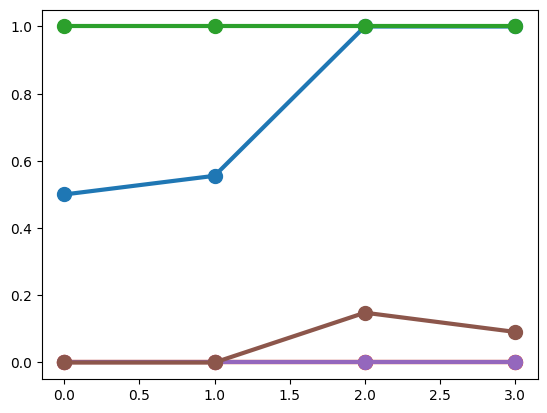

In [28]:
plt.plot(repo3['m1'], linewidth=3, marker='o', markersize=10)
plt.plot(repo3['m2'], linewidth=3, marker='o', markersize=10)
plt.plot(repo3['m3'], linewidth=3, marker='o', markersize=10)
plt.plot(repo3['m4'], linewidth=3, marker='o', markersize=10)
plt.plot(repo3['m5'], linewidth=3, marker='o', markersize=10)
plt.plot(repo3['m6'], linewidth=3, marker='o', markersize=10)

### Quality factor and aspect aggregation

- You must do this for each of your repositories

In [29]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.25
pm5 = 0.25
pm6 = 0.5

repo1['code_quality'] = ((repo1['m1']*pm1) + (repo1['m2']*pm2) + (repo1['m3']*pm3)) * psc1
repo2['code_quality'] = ((repo2['m1']*pm1) + (repo2['m2']*pm2) + (repo2['m3']*pm3)) * psc1
repo3['code_quality'] = ((repo3['m1']*pm1) + (repo3['m2']*pm2) + (repo3['m3']*pm3)) * psc1

repo1['testing_status'] = ((repo1['m4']*pm4) + (repo1['m5']*pm5) + (repo1['m6']*pm6)) * psc2
repo2['testing_status'] = ((repo2['m4']*pm4) + (repo2['m5']*pm5) + (repo2['m6']*pm6)) * psc2
repo3['testing_status'] = ((repo3['m4']*pm4) + (repo3['m5']*pm5) + (repo3['m6']*pm6)) * psc2

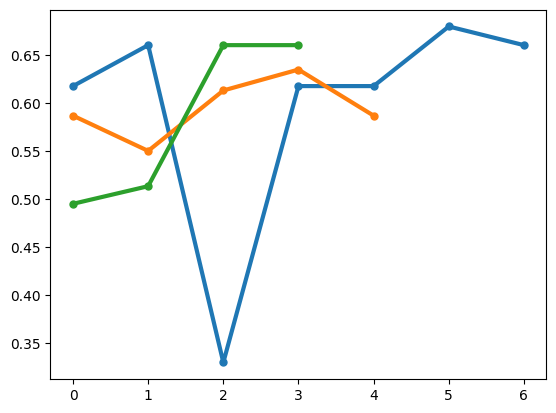

In [30]:
plt.plot(repo1['code_quality'], linewidth=3, marker='o', markersize=5)
plt.plot(repo2['code_quality'], linewidth=3, marker='o', markersize=5)
plt.plot(repo3['code_quality'], linewidth=3, marker='o', markersize=5)

In [31]:
repo1['testing_status'] = ((repo1['m4']*pm4) + (repo1['m5']*pm5) + (repo1['m6']*pm6)) * psc2
repo2['testing_status'] = ((repo2['m4']*pm4) + (repo2['m5']*pm5) + (repo2['m6']*pm6)) * psc2
repo3['testing_status'] = ((repo3['m4']*pm4) + (repo3['m5']*pm5) + (repo3['m6']*pm6)) * psc2

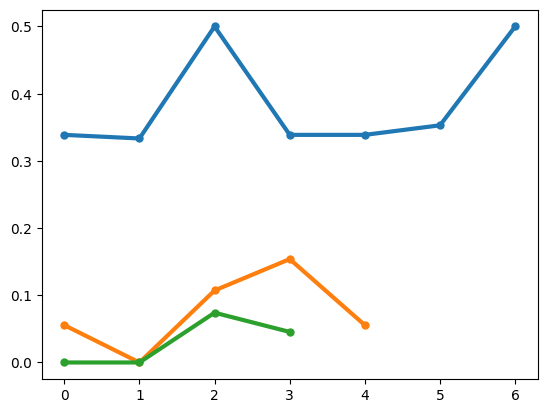

In [32]:
plt.plot(repo1['testing_status'], linewidth=3, marker='o', markersize=5)
plt.plot(repo2['testing_status'], linewidth=3, marker='o', markersize=5)
plt.plot(repo3['testing_status'], linewidth=3, marker='o', markersize=5)

In [33]:
metrics_df = pd.concat([repo1, repo2, repo3], ignore_index=True)

metrics_df['Maintainability'] = metrics_df['code_quality'] * pc1
metrics_df['Reliability'] = metrics_df['testing_status'] * pc2
metrics_df['total'] = metrics_df['Maintainability'] + metrics_df['Reliability']

In [34]:
metrics_df

,m1,m2,m3,m4,m5,m6,repository,version,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0,0.838710,0.032258,1.0,0,0,0.677419,fga-eps-mds-2022-1-Alectrion-FrontEnd,0.12.0,1254,0.617419,0.338710,0.308710,0.169355,0.478065
1,1.000000,0.000000,1.0,0,0,0.666667,fga-eps-mds-2022-1-Alectrion-FrontEnd,0.13.0,290,0.660000,0.333333,0.330000,0.166667,0.496667
2,0.000000,0.000000,1.0,0,0,1.000000,fga-eps-mds-2022-1-Alectrion-FrontEnd,0.14.0,3,0.330000,0.500000,0.165000,0.250000,0.415000
3,0.838710,0.032258,1.0,0,0,0.677419,fga-eps-mds-2022-1-Alectrion-FrontEnd,0.15.0,1254,0.617419,0.338710,0.308710,0.169355,0.478065
4,0.838710,0.032258,1.0,0,0,0.677419,fga-eps-mds-2022-1-Alectrion-FrontEnd,0.16.0,1252,0.617419,0.338710,0.308710,0.169355,0.478065
5,0.941176,0.117647,1.0,0,0,0.705882,fga-eps-mds-2022-1-Alectrion-FrontEnd,0.17.0,927,0.679412,0.352941,0.339706,0.176471,0.516176
6,1.000000,0.000000,1.0,0,0,1.000000,fga-eps-mds-2022-1-Alectrion-FrontEnd,0.18.0,59,0.660000,0.500000,0.330000,0.250000,0.580000
7,0.777778,0.000000,1.0,0,0,0.111111,fga-eps-mds-2022-1-Alectrion-UserAPI,0.12.0,235,0.586667,0.055556,0.293333,0.027778,0.321111
8,0.666667,0.000000,1.0,0,0,0.000000,fga-eps-mds-2022-1-Alectrion-UserAPI,0.13.0,40,0.550000,0.000000,0.275000,0.000000,0.275000
9,0.857143,0.000000,1.0,0,0,0.214286,fga-eps-mds-2022-1-Alectrion-UserAPI,0.14.0,433,0.612857,0.107143,0.306429,0.053571,0.360000


(0.1, 0.7)

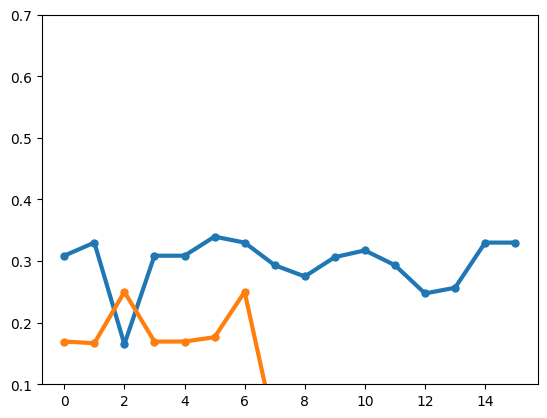

In [35]:
plt.plot(metrics_df['Maintainability'], linewidth=3, marker='o', markersize=5)
plt.plot(metrics_df['Reliability'], linewidth=3, marker='o', markersize=5)

plt.ylim(0.1,.7)

### You must do the total plot and the statics analysis for the repository with more versions.

In [36]:
# Building descriptive statistics dataframe. You must replace YourRepoName for your repository name with more product versions.

more_versions_repo = metrics_df[metrics_df['repository'] == 'fga-eps-mds-2022-1-Alectrion-FrontEnd']

def get_characteristc_stats(repo_series):
    return {
        'mean': repo_series.mean(),
        'mode': repo_series.mode(),
        'median': repo_series.median(),
        'std': repo_series.std(),
        'var': repo_series.var(),
        'min': repo_series.min(),
        'max': repo_series.max()
    }

maintainability_stats = pd.DataFrame(get_characteristc_stats(more_versions_repo["Maintainability"]),
                                     columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

reliability_stats = pd.DataFrame(get_characteristc_stats(more_versions_repo["Reliability"]),
                                 columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

In [37]:
print(maintainability_stats)

       mean     mode   median       std       var    min       max
0  0.298691  0.30871  0.30871  0.060301  0.003636  0.165  0.339706


In [38]:
print(reliability_stats)

       mean      mode    median       std       var       min   max
0  0.193029  0.169355  0.169355  0.039034  0.001524  0.166667  0.25


### Plotting the aggregated quality characteristic indicator

{'whiskers': [<matplotlib.lines.Line2D at 0x7f3525aa7e50>,
 'caps': [<matplotlib.lines.Line2D at 0x7f3525ad03d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f3525aa7b80>,
 'medians': [<matplotlib.lines.Line2D at 0x7f3525ad0970>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f3525ad0c40>,
 'means': []}

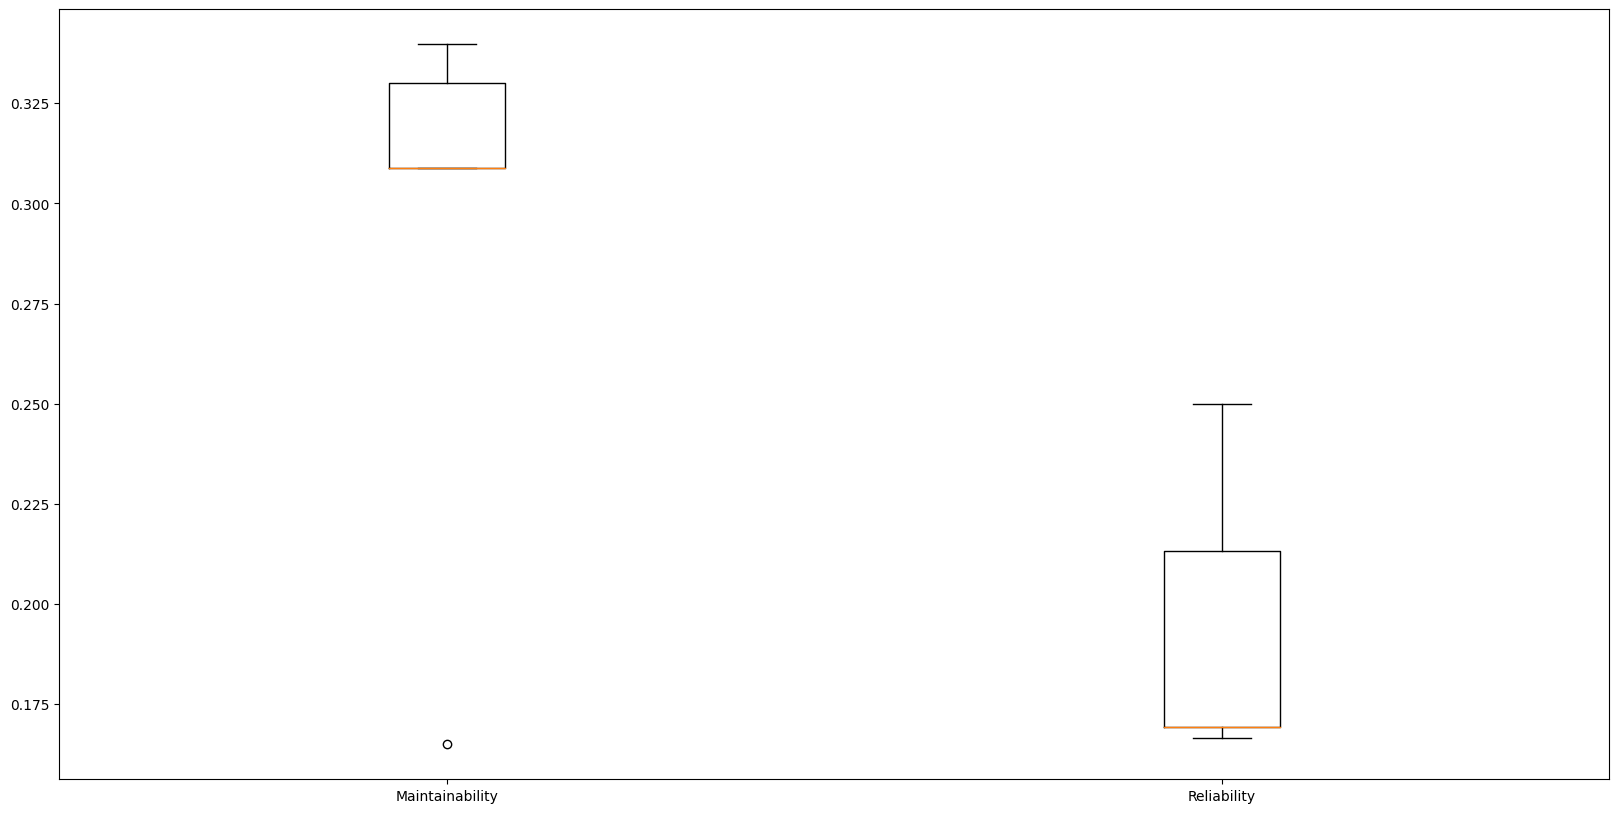

In [39]:
plt.figure(figsize=(20, 10))

# boxplot
plt.boxplot([more_versions_repo['Maintainability'], more_versions_repo['Reliability']],
labels=['Maintainability', 'Reliability'])

### Plotting the aggregated repository quality indicator

(0.1, 1.0)

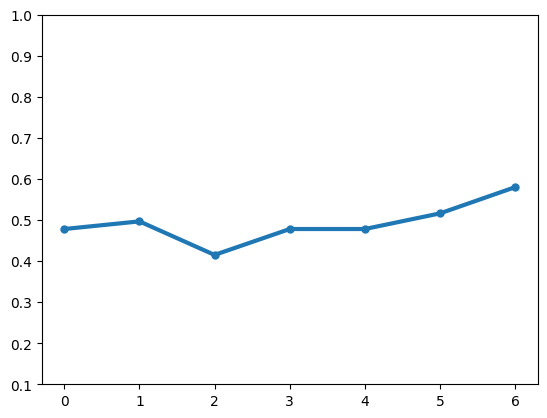

In [40]:
plt.plot(more_versions_repo['total'], linewidth=3, marker='o', markersize=5)

plt.ylim(.1,1)

In [41]:
# DATE FORMAT: MM-DD-YYYY-HH:MM:SS
currentDateTime = datetime.datetime.now().strftime("%m-%d-%Y-%H:%M:%S")

metrics_df.to_excel('data/fga-eps-mds-2022-1-Alectrion-FrontEnd-{}.xlsx'.format(currentDateTime), index = False)

metrics_df.to_csv('data/fga-eps-mds-2022-1-Alectrion-FrontEnd-{}.csv'.format(currentDateTime), index = False)